In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Depth Estimation**

##**Libraries**

In [6]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
from tensorflow.keras.layers import Input, concatenate, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from skimage.transform import resize
import os
import csv
import PIL
import numpy as np
import random
import cv2
import imutils
import tensorflow.keras.backend as K
import tensorflow as tf

##**Architecture**

In [4]:
HEIGHT = 240
WIDTH = 320
INIT_LR = 0.0001
EPOCHS = 15
def downsampling_block(input_tensor, n_filters):
  x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(input_tensor)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  return x

def upsampling_block(input_tensor, n_filters, name, concat_with):
  x = UpSampling2D((2, 2), interpolation='bilinear', name=name)(input_tensor)
  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convA")(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = concatenate([x, concat_with], axis=3)

  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convB")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convC")(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = BatchNormalization()(x)
  return x

def build(height, width, depth):
  # input
  i = Input(shape=(height, width, depth))

  # encoder
  conv1 = downsampling_block(i, 32)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = downsampling_block(pool1, 64)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = downsampling_block(pool2, 128)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = downsampling_block(pool3, 256)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

  # bottleneck
  conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
  conv5 = LeakyReLU(alpha=0.2)(conv5)
  conv5 = Conv2D(512, (3, 3), padding='same')(conv5)
  conv5 = LeakyReLU(alpha=0.2)(conv5)

  # decoder
  conv6 = upsampling_block(conv5, 256, "up1", concat_with=conv4)
  conv7 = upsampling_block(conv6, 128, "up2", concat_with=conv3)
  conv8 = upsampling_block(conv7, 64, "up3", concat_with=conv2)
  conv9 = upsampling_block(conv8, 32, "up4", concat_with=conv1)

  # output
  o = Conv2D(filters=1, kernel_size=3, strides=(1,1), activation='sigmoid', padding='same', name='conv10')(conv9)

  model = Model(inputs=i, outputs=o)
  return model

model = build(HEIGHT, WIDTH, 3)

In [5]:
model.load_weights('/content/drive/MyDrive/Depth_Estimation/Weights/weights_Depth_Estimation.h5')

#**Output Example**

In [7]:
def preprocess_image(image_path, target_height, target_width, horizontal_flip=False):
    # Load the image
    img = Image.open(image_path)

    # Resize the image
    img = img.resize((target_width, target_height), Image.ANTIALIAS)

    # Apply horizontal flip if needed
    if horizontal_flip:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)

    # Convert the image to a NumPy array
    img_array = np.array(img)

    # Normalize the array if necessary (depending on your model's requirement)
    img_array = img_array / 255.0

    return img_array

In [8]:
# Example usage
HEIGHT = 240
WIDTH = 320
x_test = np.empty((1, HEIGHT, WIDTH, 3))
x_test[0, ] = preprocess_image("/content/CAM_5_2024_05_03_10_21_07_167235_0.jpg", HEIGHT, WIDTH, horizontal_flip=False)


<ipython-input-7-6ebde8fdbf98>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((target_width, target_height), Image.ANTIALIAS)


In [9]:
pred = model.predict(x_test)
pred = np.squeeze(pred, axis=-1)
resized_image_1 = cv2.resize(pred[0],(640,480), interpolation = cv2.INTER_CUBIC)



1/1 [==============================] - 4s 4s/step


<ipython-input-12-ce041d7373a4>:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the layout to make room for the color bar


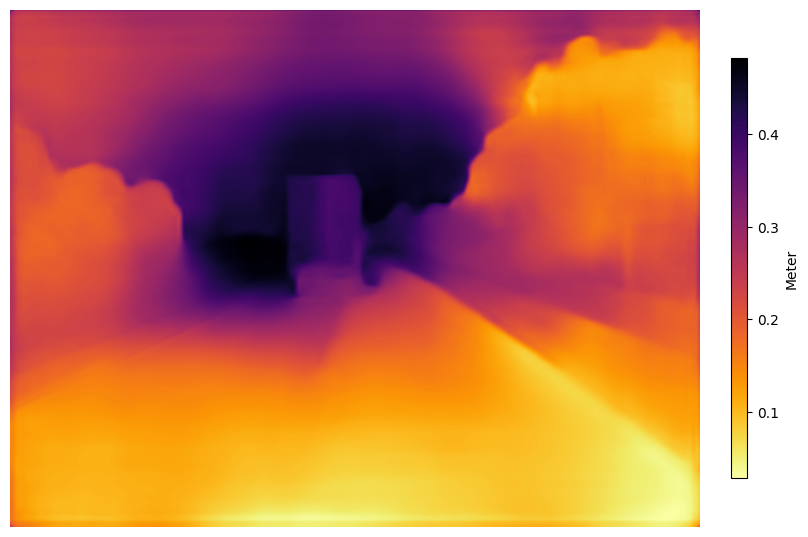

In [12]:
# Assuming 'resized_image_1' is your image data
image = resized_image_1  # Replace with your actual image data

# Determine the global min and max values (if you have multiple images to compare)
global_min = image.min()
global_max = image.max()

fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed

im = ax.imshow(image, cmap='inferno_r', vmin=global_min, vmax=global_max)
ax.axis('off')  # Hide the axis

# Add a color bar for the image
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('Meter')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the layout to make room for the color bar
plt.show()
